# Differentiation of HCN and underlying loci relative to neutral expectation

## Setup

In [1]:
# Load packages
library(data.table)
library(tidyverse)
library(R.utils)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()
Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package

In [2]:
# custom theme for plots
ng1 <- theme(aspect.ratio=0.7,panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border=element_blank(),
        axis.line.x = element_line(color="black",size=1),
        axis.line.y = element_line(color="black",size=1),
        axis.ticks=element_line(size = 1, color="black"),
        axis.ticks.length=unit(0.25, 'cm'),
        axis.text=element_text(color="black",size=15),
        axis.title=element_text(color="black",size=1),
        axis.title.y=element_text(vjust=2,size=17),
        axis.title.x=element_text(vjust=0.1,size=17),
        axis.text.x=element_text(size=15),
        axis.text.y=element_text(size=15),
        strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
        strip.background = element_rect(colour="black"),
        legend.position = "top", legend.direction="vertical", 
        legend.text=element_text(size=17), legend.key = element_rect(fill = "white"),
        legend.title = element_text(size=17),legend.key.size = unit(1.0, "cm"))

### Load summary datasets

In [3]:
# Load urban and rural 4fold allele frequencies for all cities as single dataframe
df_afs <- suppressMessages(list.files('../analyses/tables/hcn_diff/4fold_afs/', recursive = TRUE, full.names = TRUE) %>% 
                          map_dfr(., read_delim, delim = '\t'))
# Load dataset with Fst values for 4fold sites along Ac and Li chromosomes for each city
Ac_Li_chrom_4fold_fst_df <- suppressMessages(read_delim('../analyses/tables/Ac_Li_diff/Ac_Li_chrom_4fold_fst.txt.bz2', 
                                                        delim = '\t'))

### Functions used for analyses

In [6]:
# Estimate HCN frequency from allele frequencies at two loci
estimate_hcn <- function(pA, pB){
    qA <- 1 - pA
    qB <- 1 - pB
    hcn <- (2*pA*qA + pA^2) * (2*pB*qB + pB^2)
    return(hcn)
}

# Estimate Fst from urban and rural allele frequencies
estimate_fst <- function(p_u, p_r){
    
    q_u <- 1 - p_u
    q_r <- 1 - p_r
    
    HT <- ((p_u + p_r) / 2)^2 + (( q_u + q_r) / 2)^2
    HS <- (p_u^2 + p_r^2 + q_u^2 + q_r^2) / 2
    
    fst <- (HS - HT) / (1 - HT)
    
    return(fst)
}

# Find positions with allele frequency estimates in both habitats
intersect_positions <- function(df){
    
    df_out <- df %>%
        filter(pos %in% (df %>% 
                         group_split(site) %>% 
                         map(~pull(., pos)) %>% 
                         reduce(intersect)))
    return(df_out)
}

# Simulate null distribution by randomly sample 4fold sites "nreps" times
simulate_null <- function(df, nreps = 1000){
    
    city <- df %>% pull(city) %>% unique()
    stats_out <- c()
    
    for(i in 1:nreps){
        # Randomly sample 2 sites
        random_sites <- sample_n(df, size = 2)

        # Get mock "Ac" and "Li" allele frequencies in each habitat
        Ac_r <- random_sites[1, 'knownEM_r'] %>% pull()
        Li_r <- random_sites[2, 'knownEM_r'] %>% pull()
        Ac_u <- random_sites[1, 'knownEM_u'] %>% pull()
        Li_u <- random_sites[2, 'knownEM_u'] %>% pull()

        # Estimate mock HCN frequency in each habitat
        r_hcn <- estimate_hcn(Ac_r, Li_r)
        u_hcn <- estimate_hcn(Ac_u, Li_u)

        # Estimate differentiation stats as measure of differentiation in mock HCN
        fst <- estimate_fst(u_hcn, r_hcn)

        stats_out[i] <- fst
    }
    
    out <- tibble(city = city, rep = 1:nreps, fst = stats_out)
    return(out)
}

 # Function to estimate P-values by comparing observed value against null distribution
permutation_pval <- function(df){
    city <- df %>% pull(city) %>% unique()
    obs_val <- df %>% filter(is.na(rep)) %>% pull(fst)
    perm_val <- df %>% filter(!(is.na(rep))) %>% pull(fst)
    pval <- sum(abs(perm_val) >= abs(obs_val)) / length(perm_val)
    df_out <- data.frame(city = city, pval = pval)
    return(df_out)
}

# Function to load genotype likelihoods
load_gls <- function(inpath){
    
    to_remove <- suppressMessages(
        read_table('../../../results/program_resources/highErrorRate_toRemove.txt', 
                   col_names = FALSE)) %>% 
        pull()
    df <- suppressMessages(read_delim(inpath, delim = '\t')) %>% 
        dplyr::select(sample, ends_with('norm')) %>% 
        filter(!(sample %in% to_remove)) %>% 
        left_join(sample_sheet, by = 'sample')
    
    return(df)
}

# Estimate Hudson's Fst at a locus
hudson_fst <- function(p_u, p_r, n_u, n_r){
    
    # Numerator
    a <- (p_u - p_r)^2
    b <- (p_u * (1 - p_u)) / (n_u - 1)
    c <- (p_r * (1 - p_r)) / (n_r - 1)
    num <- a - b - c
    
    # Denominator
    d <- p_u * (1 - p_r)
    e <- p_r * (1 - p_u)
    denom <- d + e
    
    fst <- num / denom
   
    return(fst)
}

# Estimate allele frequency from genotype likelihoods
estimate_p <- function(df, by_site = TRUE){
    
    if(by_site == TRUE){
        df_out <- df %>% 
            group_by(city, site) %>% 
            summarise(num_aa = sum(l_aa_norm),
                      num_Aa = sum(l_Aa_norm),
                      num_AA = sum(l_AA_norm),
                      n = 2*n(),
                      p = (num_aa + (0.5 * num_Aa)) / sum(num_aa, num_Aa, num_AA)) %>% 
            dplyr::select(-starts_with('num_')) %>% 
            pivot_wider(names_from = site, values_from = c('n', 'p')) %>% 
            mutate(fst = hudson_fst(p_u, p_r, n_u, n_r)) %>% 
            left_join(., betaLog, by = 'city')
    }else{
        df_out <- df %>% 
            group_by(city) %>% 
            summarise(num_aa = sum(l_aa_norm),
                      num_Aa = sum(l_Aa_norm),
                      num_AA = sum(l_AA_norm),
                      p = (num_aa + (0.5 * num_Aa)) / sum(num_aa, num_Aa, num_AA)) %>% 
            dplyr::select(-starts_with('num_'))
    }
    
    return(df_out)
}

# Get threshold quantile value from distribution
get_quantile <- function(df, probs = c(0.975)){
    
    city <- df %>% pull(city) %>% unique()
    locus <- df %>% pull(locus) %>% unique()
    fst <- df %>% filter(!(is.na(fst))) %>% pull(fst)
    
    quant <- quantile(fst, probs = probs)
    df_out <- data.frame(city = city, locus = locus, quant = quant)
    return(df_out)
}

## HCN differentiation analysis

For each city, test whether urban-rural divergence in HCN is greater than expected based on null distribution of randomly selected 4fold degenerate sites with a similar genetic architecture as HCN. Treating the HCN phenotype as if it were a single locus, the basic approach for this test is as follows:

1. Estimate urban and rural HCN frequencies from binomial regressions performed separately on each city. Urban HCN is the predicted value when standardized distance = 0, while rural HCN is the predicted value when standardized distance = 1
2. From these urban and rural HCN frequencies, calculate observed urban-rural differentiation in HCN using $F_{ST}$ formulas defined below
3. Generate a null distribution of $F_{ST}$ using genome-wide 4fold degenerate sites. Using 4fold site allele frequencies estimated separately in urban and rural habitats for each city, perform the following procedure:  
    **A.** Remove sites with fewer than 10 individuals contributing to frequency estimates so that considered sites have decent power to accurately estimate frequencies  
    **B.** Consider only sites with frequencies estimated for the same minor alleles in urban and rural habitats.  
    **C.** Randomly sample two 4fold sites and assign one site to be "_Ac_" and the other to be "_Li_" <br>
    **D.** Estimate "HCN" in each habitat separately using these "_Ac_" and "_Li_" frequencies. If $p_A$ is the frequency of the functional _Ac_ allele and $p_B$ the frequency of the functional "_Li_" allele, HCN can be estimated as $(2p_Aq_A + p_A^2) * (2p_Bq_B + p_B^2)$  
    **E.** Using the urban and rural "HCN" frequencies, estimate urban-rural differentiation in "HCN"  
    **F.** Repeat (C) to (E) 1000 times to generate null distribution of $F_{ST}$ using genome-wide 4fold sites  
    **G.** Calculate a P-value as the proportion of simulated $F_{ST}$  estimates greater or equal to the observed $F_{ST}$ value
    
### Details of Fst estimation

$F_{ST}$ formulae were pulled from Jakobsson _et. al._ 2013

We estimated $F_{ST}$ as:

$$F_{ST} = \frac{H_S - H_T}{1 - H_T}$$

where $H_T$ is homozygosity of the total population and $H_S$ is the mean homozygosity across subpopulations (Nei, 1973; Jakobsson _et. al._ 2013). Assume one polymorphic locus with two alleles (HCN+ and HCN- in our case) and $K$ subpopulations (2 in our case -- urban and rural). For $I$ distinct alleles, the frequency of allele $i$ in population $k$ is $p_{ki}$, and the mean frequency of allele $i$ across populations is $p_i = \frac{1}{K}\sum_{k=1}^{K}p_{ki}$. $H_T$ and $H_S$ can be calculates as follows:

$$H_T = \sum_{i=1}^{I}(\frac{1}{K}\sum_{k=1}^{K}p_{ki})^2$$

$$H_S = \frac{1}{K}\sum_{k=1}^{K}\sum_{i=1}^{I}p_{ki}^2$$

In [7]:
# Get sites common to urban and rural habitats, seaprately for each city
# Pivot data for easier random site selection
# Use only sites with same major and minor alleles
df_afs_inter <- df_afs %>%
    group_split(city) %>%
    map_dfr(., intersect_positions) %>%
    pivot_wider(names_from = site, values_from = c(knownEM, nInd, minor)) %>%
    filter(minor_u == minor_r)
head(df_afs_inter)

city,pos,major,knownEM_r,knownEM_u,nInd_r,nInd_u,minor_r,minor_u
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Albuquerque,CM019101.1_17063,A,0.522677,0.633789,13,10,C,C
Albuquerque,CM019101.1_17462,T,0.144811,0.157838,13,13,A,A
Albuquerque,CM019101.1_19481,C,0.741929,0.661749,13,13,A,A
Albuquerque,CM019101.1_19520,G,0.746196,0.806513,13,13,A,A
Albuquerque,CM019101.1_19553,A,0.638462,0.828019,12,10,T,T
Albuquerque,CM019101.1_47203,C,0.880891,0.965221,23,19,G,G


In [8]:
# Number of sites considered for each city
df_afs_inter %>% 
    group_by(city) %>% 
    summarise(nSites = n())

city,nSites
<chr>,<int>
Albuquerque,305466
Antwerp,298072
Armidale,272253
Athens,296244
Bogota,70797
Buenos_Aires,252545
Calgary,363805
Canberra,37496
Cape_Town,272374


In [9]:
# Load in sample sheet
# Load binomial regression model summaries and predict urban and rural HCN
sample_sheet <- suppressMessages(read_delim('../resources/glue_pc_sampleSheet.txt', delim = '\t'))
betaLog <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/supplementary-tables/allCities_logisticReg_coefs.csv'))
obs_hcnFst <- betaLog %>% 
    filter(city %in% sample_sheet$city) %>% 
    mutate(hcn_u = exp(yint_Dist + betaLog_Dist*0) / (1 + (exp(yint_Dist + betaLog_Dist*0))),
           hcn_r = exp(yint_Dist + betaLog_Dist*1) / (1 + (exp(yint_Dist + betaLog_Dist*1)))) %>% 
    mutate(sig = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No')) %>% 
    mutate(fst = round(estimate_fst(hcn_u, hcn_r), 3)) %>% 
    dplyr::select(city, sig, hcn_u, hcn_r, fst)
head(obs_hcnFst)

city,sig,hcn_u,hcn_r,fst
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Albuquerque,Yes,0.30470333,0.1592258,0.030
Antwerp,Yes,0.09673856,0.4790123,0.178
Armidale,Yes,0.55354390,0.8457958,0.102
Athens,Yes,0.35755317,0.7269097,0.137
Bogota,Yes,0.29629576,0.4935004,0.041
Buenos_Aires,No,0.75565431,0.7584133,0.000


In [10]:
# Get null distributions of fst separately for each city
set.seed(42)
nulls <- df_afs_inter %>% 
    group_split(city) %>% 
    map_dfr(~simulate_null(., nreps = 1000))

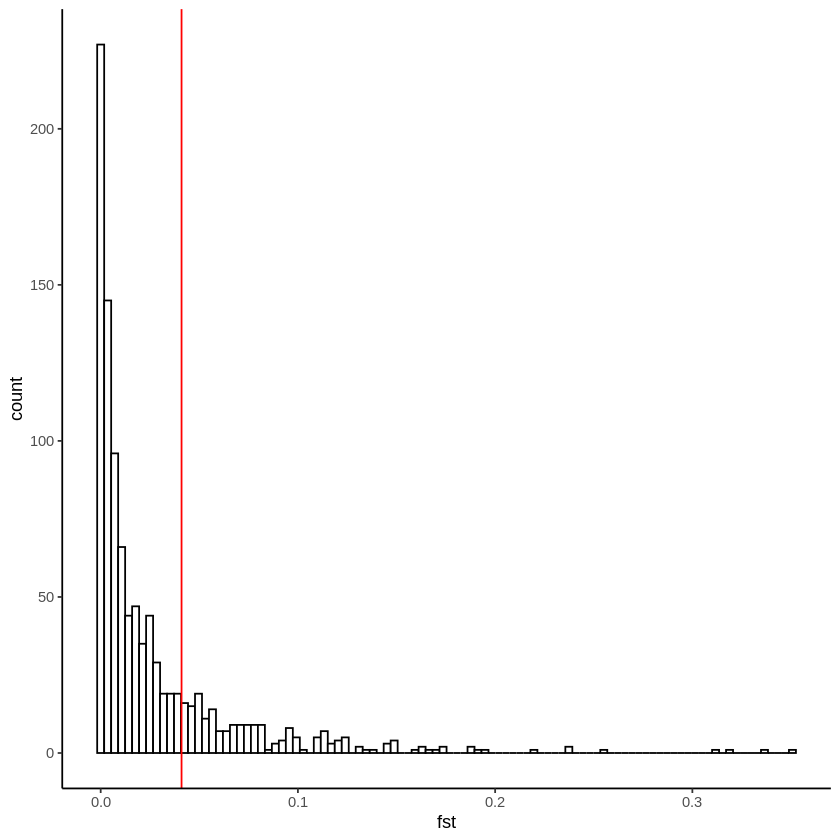

In [11]:
# Example permutation test
nulls %>% filter(city == 'Bogota') %>% 
    ggplot(aes(x = fst)) +
    geom_histogram(bins = 100, color = 'black', fill = 'white') +
    geom_vline(xintercept = obs_hcnFst %>% filter(city == 'Bogota') %>% pull(fst), color = 'red') +
    theme_classic()

In [12]:
# Combine observed and permutes Fst into single dataframe for permutation test
combine_stats_sf <- obs_hcnFst %>% 
    dplyr::select(city, fst) %>% 
    bind_rows(nulls)

In [13]:
# Perform permutation test, separately for each city
perm_pval_df <- combine_stats_sf %>% 
    group_split(city) %>% 
    purrr::map_dfr(., permutation_pval) %>% 
    left_join(obs_hcnFst %>% dplyr::select(city, sig)) %>% 
    mutate(sig_perm = ifelse(pval < 0.05, 1, 0)) %>% 
    mutate(match_expect = ifelse(sig == sig_perm, 'Yes', 'No'))

Joining, by = "city"


In [14]:
perm_pval_df

city,pval,sig,sig_perm,match_expect
<chr>,<dbl>,<chr>,<dbl>,<chr>
Albuquerque,0.211,Yes,0,No
Antwerp,0.006,Yes,1,No
Armidale,0.032,Yes,1,No
Athens,0.021,Yes,1,No
Bogota,0.210,Yes,0,No
Buenos_Aires,1.000,No,0,No
Calgary,0.103,Yes,0,No
Canberra,1.000,No,0,No
Cape_Town,0.292,No,0,No


In [15]:
# Chi-square test
chisq_table <- table(perm_pval_df$sig, perm_pval_df$sig_perm)
print(chisq_table)
chisq.test(chisq_table, correct = FALSE)

     
      0 1
  No  9 0
  Yes 8 9


Warning message in chisq.test(chisq_table, correct = FALSE):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  chisq_table
X-squared = 7.2872, df = 1, p-value = 0.006945


## Ac and Li loci differentiation analysis

For each city, we examine whether the two loci underlying HCN production (_Ac_ and _Li_) were more differentiated than expected given baackground levels of differentiation at 4fold sites along the same chromosomes. We used _ANGSD_ to estimate Hudson's $F_{ST}$ at all 4fold SNPs along the same chromosomes as _Ac_ and _Li_, and compared observed $F_{ST}$ at _Ac_ and _Li_ to these distributions. We considered loci significant outliers if their $F_{ST}$ values were in the top 2.5% of the $F_{ST}$ distribution for 4fold sites along the same chromosome. _Ac_ and _Li_ frequencies were calculated from genotype likelihoods calculated from raw read counts overlapping the genes. 

In [16]:
# Load in genotype likelihoods for all samples at both loci
ac_gls <- load_gls('../../../results/hcn_genotyping/ac_GLs.txt')
li_gls <- load_gls('../../../results/hcn_genotyping/li_GLs.txt')
nrow(ac_gls)

[1] 2055

In [17]:
# Estimate urban and rural allele frequencies from genotype likelihoods
ac_freq <- estimate_p(ac_gls, by_site = TRUE) %>% mutate(locus = 'ac')
li_freq <- estimate_p(li_gls, by_site = TRUE) %>% mutate(locus = 'li')

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


In [18]:
# Combine Ac and Li allele frequencies
all_freqs <- bind_rows(ac_freq, li_freq) %>% 
    arrange(city)
head(all_freqs)

city,n_r,n_u,p_r,p_u,fst,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent,betaLog_fromGlobalModel,locus
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
Albuquerque,94,92,0.2541680,0.3260111,0.001709459,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,-0.425,ac
Albuquerque,94,92,0.7392460,0.5092263,0.097036908,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,-0.425,li
Antwerp,96,96,0.2898515,0.3042396,-0.010025509,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,2.142,ac
Antwerp,96,96,0.7989247,0.8375313,-0.005475581,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,2.142,li
Armidale,94,90,0.2267613,0.2712620,-0.005669832,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,0.320,ac
Armidale,94,90,0.4340181,0.5752685,0.028562562,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,0.320,li


In [19]:
# Get threshold value for top 2.5% of distributions for each city and locus
neutral_fst_quantile_df <- Ac_Li_chrom_4fold_fst_df %>% 
    group_split(city, locus) %>% 
    map_dfr(., get_quantile)

In [20]:
# Outlier test. Separate for each locus and city. 
all_stats_df <- left_join(all_freqs, neutral_fst_quantile_df, by = c('city', 'locus')) %>% 
    mutate(fst = ifelse(fst < 0, 0, fst),
           is_outlier = ifelse(fst > quant, 1, 0)) %>% 
    dplyr::select(-starts_with('n_'), -starts_with('p_'), -continent) %>% 
    mutate(sig = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No'))

In [21]:
# Add column for whether or no at least one locus is an outlier
all_stats_df_wide <- all_stats_df %>% 
    pivot_wider(names_from = 'locus', values_from = c('is_outlier', 'quant', 'fst')) %>% 
    mutate(one_outlier = ifelse(is_outlier_ac == 1 | is_outlier_li == 1, 'Yes', 'No')) %>% 
    group_by(sig, one_outlier)

In [22]:
# Chi squared test
chisq_table <- table(all_stats_df_wide$sig, all_stats_df_wide$one_outlier)
chisq.test(chisq_table, correct = FALSE)

Warning message in chisq.test(chisq_table, correct = FALSE):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  chisq_table
X-squared = 3.3462, df = 1, p-value = 0.06736


In [23]:
chisq_table

     
      No Yes
  No   6   3
  Yes  5  12

# Generate summary datasets

**Note: This section only needs to be run to generate the summary datasets from the raw data output by the Snakemake pipeline. If the Snakemake pipeline hasn't been run, then the manuscript's results can be reproduced by running the analyses above using the summary datasets, which are available on [GitHub](../analyses/tables) and archived on Zenodo**

## Functions used to generate summary datasets

In [56]:
# Load urban and rural 4fold allele frequencies for city in "path"
load_maf <- function(path){
    
    city <- basename(dirname(path))
    base = basename(path)
    site <- str_extract(base, pattern = '(?<=_)[r|u]')

    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        filter(nInd >= 10) %>%
        mutate(city = city, 
               site = site,
               pos = paste(chromo, position, sep = '_')) %>%
    dplyr::select(city, site, pos, everything(), -'pK-EM', -ref, -anc, -chromo, -position) %>%
    return(df)
}

# Function to write bzipped text file with 4fold allele frequencies for each city
write_maf_df <- function(df){
    
    city <- df %>% pull(city) %>% unique()
    outpath <- sprintf('../analyses/tables/hcn_diff/4fold_afs/%s_urban-rural_4fold-afs.txt', city)
    write_delim(df, outpath, delim = '\t')
    bzip2(outpath, ext = 'bz2', FUN = bzfile)
}

load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(dirname(path))
    locus <- str_split(dirname(path), pattern = '/', simplify = TRUE)[2]
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>%
    
    # Cap numerators at 0 if negative
    # https://github.com/ANGSD/angsd/issues/309 # Does not affect overall pattern 
    mutate(num = ifelse(num < 0, 0, num),
           fst = num / denom) %>%
    mutate(city = city,
           locus = locus)
    
    return(df)
}

## Write dataframes

### HCN differentiation analysis

In [57]:
paths <- c('../analyses/tables/hcn_diff',
           '../analyses/tables/hcn_diff/4fold_afs',
           '../analyses/tables/Ac_Li_diff/')
purrr::walk(paths, dir.create)

Warning message in .f(.x[[i]], ...):
“'../analyses/tables/hcn_diff' already exists”Warning message in .f(.x[[i]], ...):
“'../analyses/tables/hcn_diff/4fold_afs' already exists”

In [28]:
# Load all 4fold allele frequencies as single dataframe and then write AFs to disk by city
inpath <- '../../../results/angsd/afs/by_city/'
list.files(inpath, full.names = TRUE, recursive = TRUE, pattern = '*[u|r]_4fold.mafs.gz') %>%
    map_dfr(., load_maf) %>% 
    group_split(city) %>% 
    walk(., write_maf_df)

### Ac and Li differentiation test

In [58]:
inpath <- '../../../results/angsd/summary_stats/fst/fst1/'
Ac_Li_chrom_4fold_fst_df <- list.files(inpath, pattern = '.*_(ac|li)_4fold_r_u_fst1_readable.fst', recursive = TRUE)  %>% 
    map_dfr(., load_obs_fst)

chrom,pos,num,denom,fst,city,locus
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CM019103.1,16295,0.031660,0.480412,0.0659017676,Albuquerque,ac
CM019103.1,16460,0.000107,0.236729,0.0004519936,Albuquerque,ac
CM019103.1,16535,0.001080,0.332435,0.0032487554,Albuquerque,ac
CM019103.1,16658,0.001752,0.466036,0.0037593662,Albuquerque,ac
CM019103.1,16661,0.000000,0.252031,0.0000000000,Albuquerque,ac
CM019103.1,16799,0.000000,0.152620,0.0000000000,Albuquerque,ac


In [60]:
outpath <- '../analyses/tables/Ac_Li_diff/Ac_Li_chrom_4fold_fst.txt'
write_delim(obs_fst_df, outpath, delim = '\t')
bzip2(outpath, ext = 'bz2', FUN = bzfile)